In [1]:
import os
import time
import pickle
from multiprocessing import Pool
import itertools

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler


os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [20]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')


In [3]:
@np.vectorize
def bgs_rec(mu, s, r, L):
    return np.exp(-L * mu/(s*(1+(1-s)*r/s)**2))

## Data

In [4]:
with open('../msprime_sims/bgs_rec_1rep_linear.pkl', 'rb') as f:
    params, bhats = pickle.load(f)
X = np.array(params)
#y = np.log10(np.array(bhats).mean(axis=1))
#y = np.log10(np.array(bhats))
y = np.array(bhats)

In [5]:
X.shape

(1000000, 6)

In [6]:
# 0   1  2  3  4  5
# mu  s  r  N  L  nreps

X_train, X_test, y_train, y_test = train_test_split(X[:, (0, 1, 2, 4)], y,  test_size=0.10, random_state=1)
X_scaler = StandardScaler().fit(X_train)
X_train_normalized = X_scaler.transform(X_train)

In [7]:
X_test_normalized = X_scaler.transform(X_test)

## Network and Training

In [43]:
def network(n64=4, n32=2, output_activation='sigmoid'):
    # build network
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(4,)))
    #model.add(layers.BatchNormalization(axis=1))
    for i in range(n64):
        model.add(layers.Dense(64, activation='elu'))
        #model.add(layers.Dropout(0.2))
    for i in range(n32):
        model.add(layers.Dense(32, activation='elu'))
        #model.add(layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1, activation=output_activation))
    model.compile(
        optimizer='Adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['MeanAbsoluteError'],
        )
    return model

In [45]:
model = network(output_activation='linear')
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                   patience=50, restore_best_weights=True)
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

history = model.fit(X_train_normalized, y_train, 
                    validation_split=0.2, 
                    #validation_data=(X_test_normalized, y_test),
                    batch_size=128, epochs=500, verbose=0, callbacks=[es, tqdm_callback])

Training:   0%|                                                                                               …

Restoring model weights from the end of the best epoch: 71.
Epoch 00121: early stopping


In [46]:
predict = model.predict(X_test_normalized).squeeze()

In [47]:
predict.max()

0.99849486

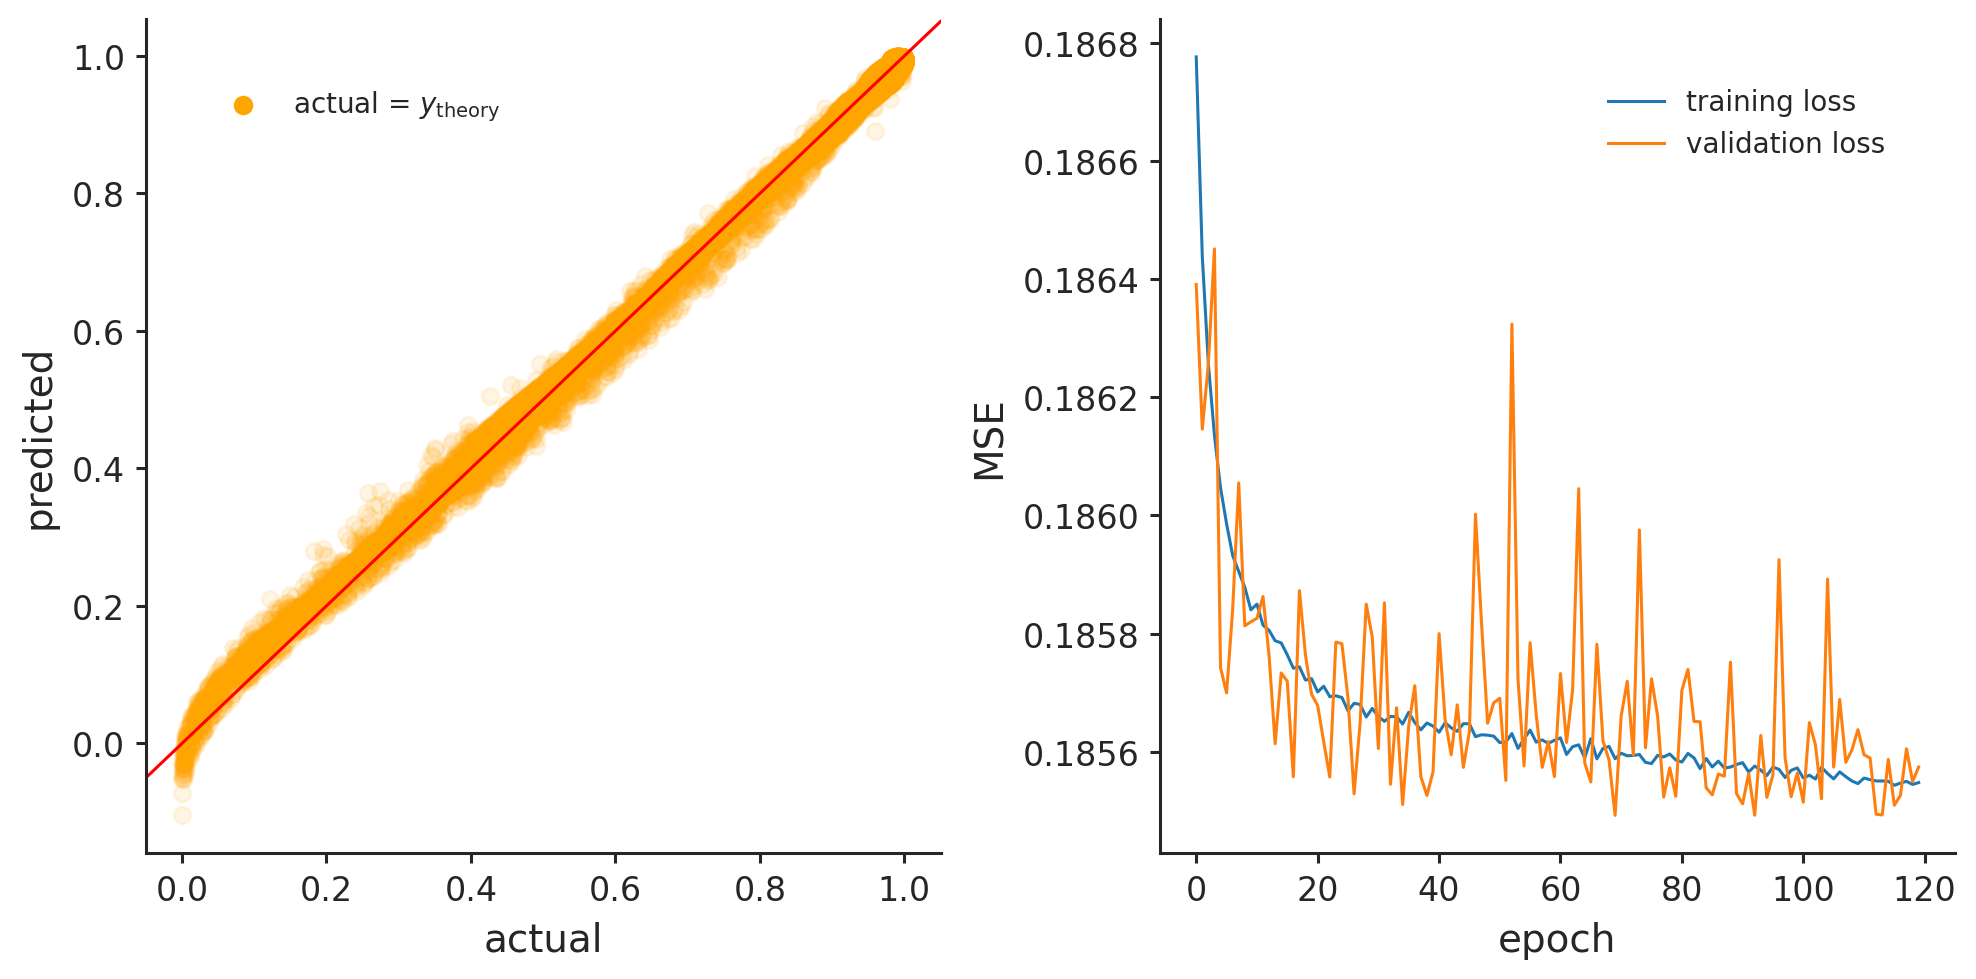

In [49]:
y_theory = bgs_rec(X_test[:, 0], X_test[:, 1], X_test[:, 2], X_test[:, 3])


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
#points_yhat = ax1.scatter(y_test, predict, label='actual = $y_\mathrm{test}$')
points_ytheory = ax1.scatter(y_theory, predict, c='orange', label='actual = $y_\mathrm{theory}$')
ax1.legend()
points_yhat.set_alpha(0.1)
points_ytheory.set_alpha(0.1)


ax1.axline((0, 0), slope=1, c='r')
ax2.plot(history.history['loss'][1:], label='training loss')
ax2.plot(history.history['val_loss'][1:], label='validation loss')
ax2.set_ylabel("MSE")
ax2.set_xlabel("epoch")
ax1.set_xlabel("actual")
ax1.set_ylabel("predicted")
#ax2.set_ylim((0, 1))
ax2.legend()
plt.tight_layout()

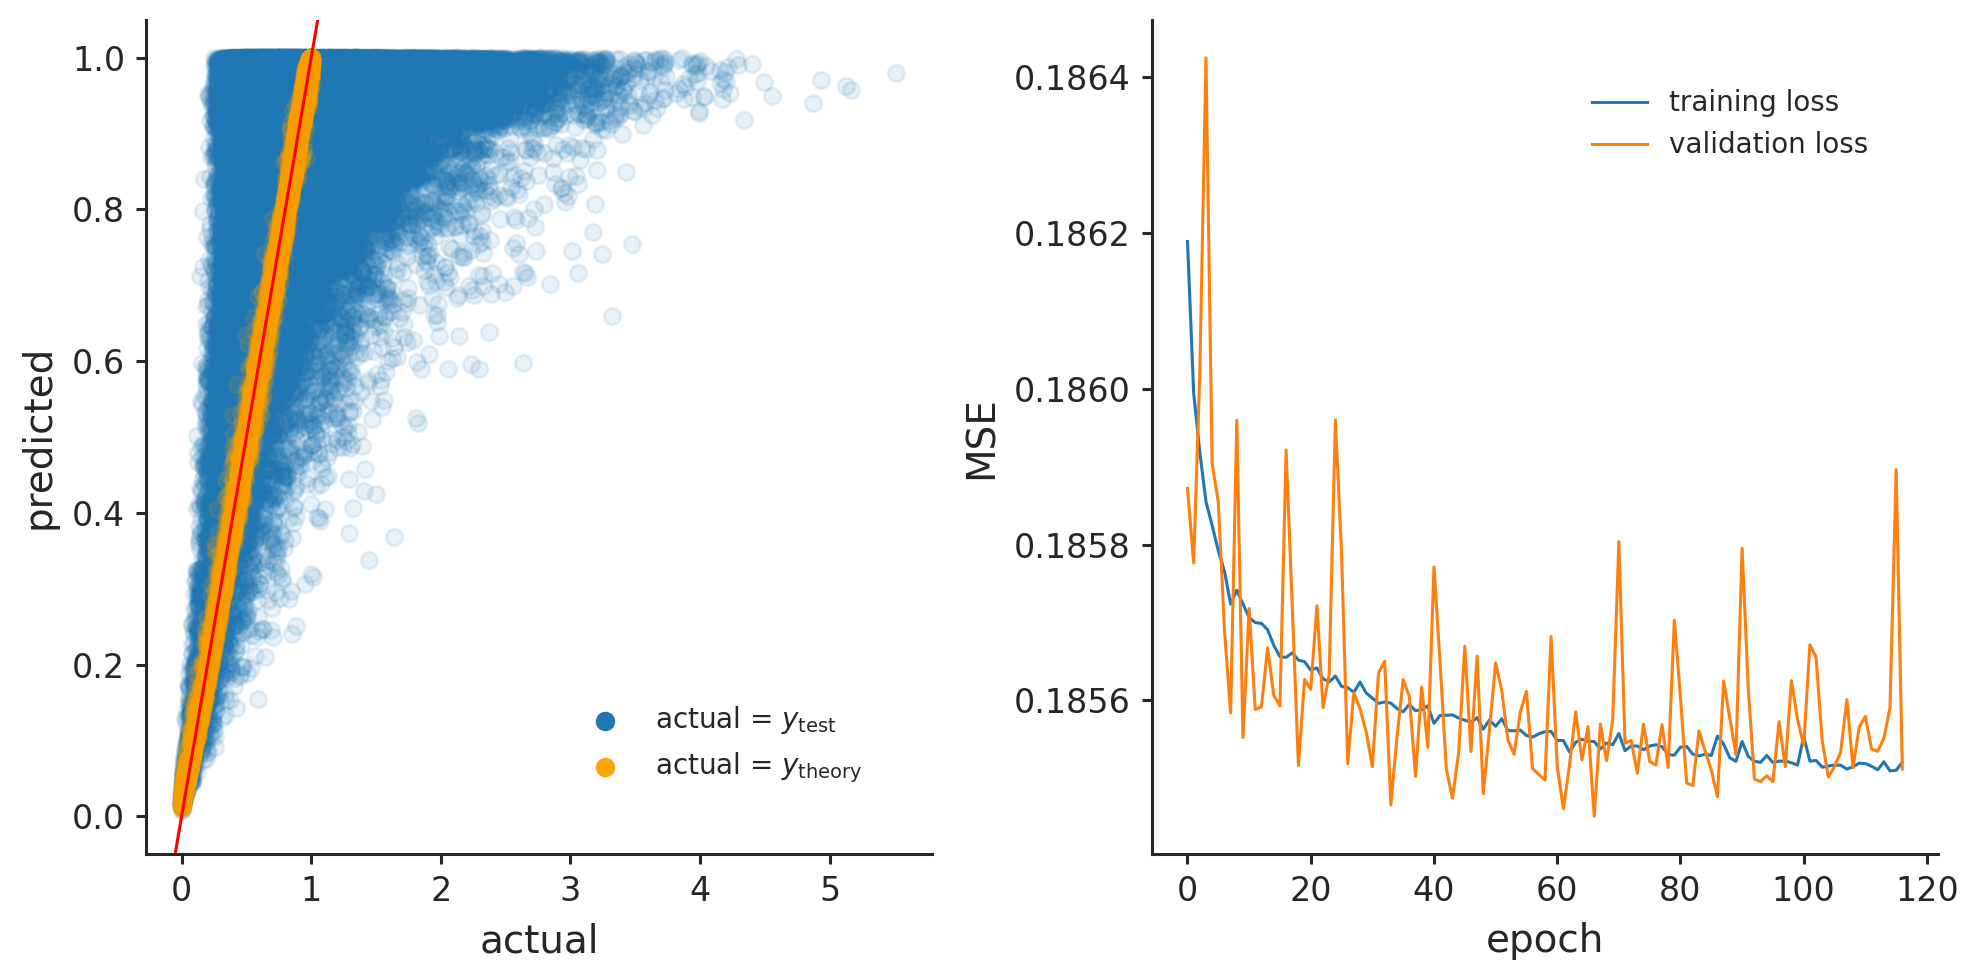

In [36]:
y_theory = bgs_rec(X_test[:, 0], X_test[:, 1], X_test[:, 2], X_test[:, 3])


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
points_yhat = ax1.scatter(y_test, predict, label='actual = $y_\mathrm{test}$')
points_ytheory = ax1.scatter(y_theory, predict, c='orange', label='actual = $y_\mathrm{theory}$')
ax1.legend()
points_yhat.set_alpha(0.1)
points_ytheory.set_alpha(0.1)


ax1.axline((0, 0), slope=1, c='r')
ax2.plot(history.history['loss'][1:], label='training loss')
ax2.plot(history.history['val_loss'][1:], label='validation loss')
ax2.set_ylabel("MSE")
ax2.set_xlabel("epoch")
ax1.set_xlabel("actual")
ax1.set_ylabel("predicted")
#ax2.set_ylim((0, 1))
ax2.legend()
plt.tight_layout()

In [12]:
np.abs(predict.flatten() - y_test.flatten()).mean(), np.abs(predict.flatten() - y_theory.flatten()).mean()

(0.31771801218842094, 0.004511955955328384)

Text(0, 0.5, 'B')

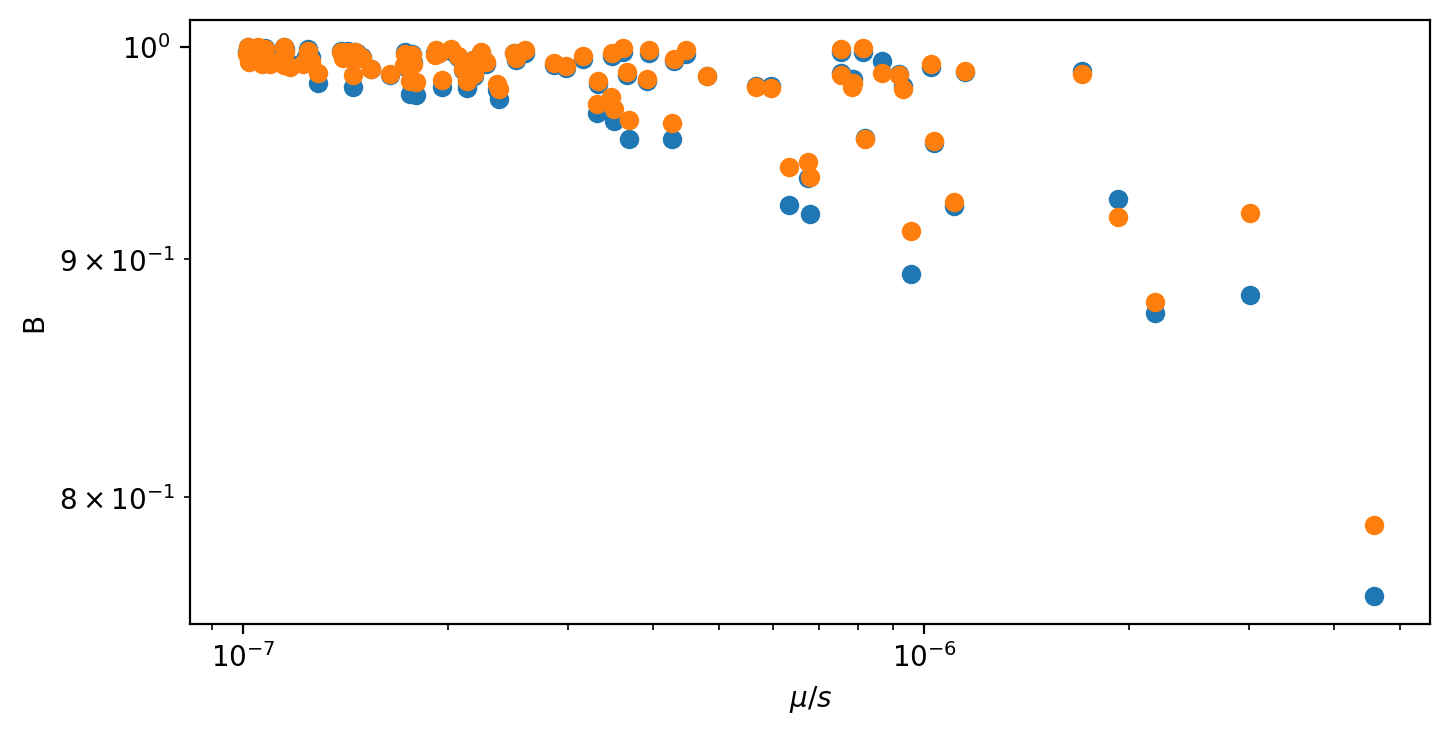

In [13]:
n = 100
s = np.random.uniform(1e-3, 1e-1, n)
mu = np.random.uniform(1e-8, 1e-8, n)
rbp = np.random.uniform(1e-7, 1e-9, n)
L = np.random.uniform(10, 100_000, n)
N = np.random.uniform(50, 10_000, n)
xnew = np.array((mu, s, rbp, N, L)).T

#'N', 's', 'h', 'mu', 'recfrac', 'rbp', 'seglen'
xnew = np.array((mu, s, rbp, L)).T
rate = xnew[:, 0]/xnew[:, 1]
fig, ax = plt.subplots()
ax.scatter(rate, model.predict(X_scaler.transform(xnew)))
ax.scatter(rate, bgs_rec(mu, s, rbp, L))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mu/s$')
ax.set_ylabel('B')